In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
from utils import *

i1 = plt.imread('n1_small.jpg')
i2 = plt.imread('n2_small.jpg')
i1 = i1.mean(axis=2)
i2 = i2.mean(axis=2)
h1 = harris_response(i1)
h2 = harris_response(i2)
fig, axs = plt.subplots(ncols=2, figsize=(12, 8))
axs[0].imshow(h1)
axs[1].imshow(h2)
plt.show()

<Figure size 1200x800 with 2 Axes>

In [2]:
x1, y1 = local_max(h1)
x2, y2 = local_max(h2)
x1, y1 = adaptive_suppression(h1, y1, x1)
x2, y2 = adaptive_suppression(h2, y2, x2)

d1, out_x1, out_y1 = extract_descriptors(i1, x1, y1)
d2, out_x2, out_y2 = extract_descriptors(i2, x2, y2)

In [3]:
ix1, ix2 = match_descriptors(d1, d2, out_x1, out_y1, out_x2, out_y2)

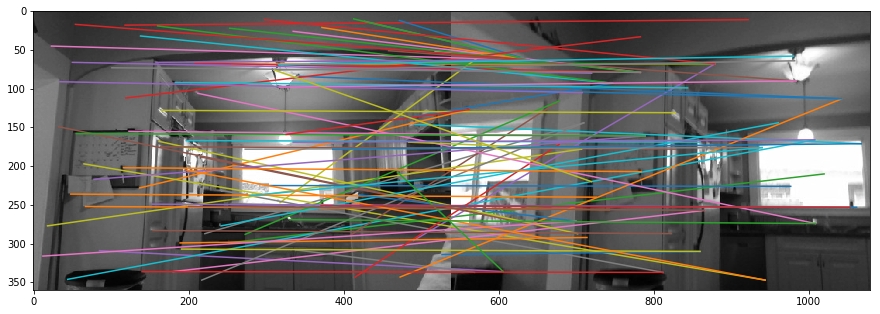

In [4]:
match_x1, match_y1 = unpack(ix1)
match_x2, match_y2 = unpack(ix2)
match_x2 += i1.shape[1]

out_im = np.concatenate((i1, i2), axis=1)
plt.figure(figsize=(15, 12))
plt.imshow(out_im, cmap='gray')
for x, y, xx, yy in zip(match_x1, match_y1, match_x2, match_y2):
    plt.plot([x, xx], [y, yy])
plt.show()

In [5]:
ix1, ix2 = match_descriptors_threshold(d1, d2, out_x1, out_y1, out_x2, out_y2)

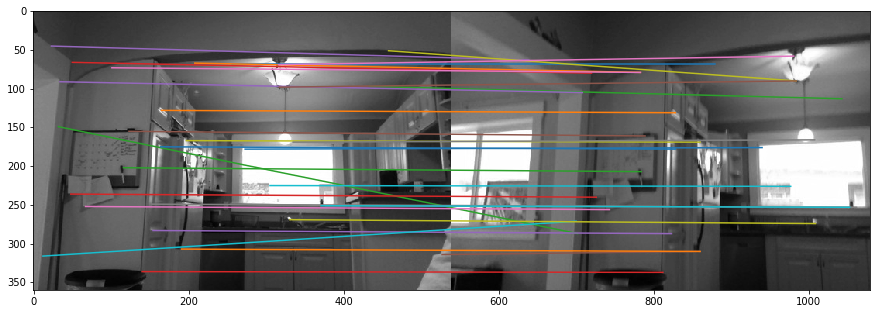

In [6]:
match_x1, match_y1 = unpack(ix1)
match_x2, match_y2 = unpack(ix2)
match_x2 += i1.shape[1]

out_im = np.concatenate((i1, i2), axis=1)
plt.figure(figsize=(15, 12))
plt.imshow(out_im, cmap='gray')
i = 0
for x, y, xx, yy in zip(match_x1, match_y1, match_x2, match_y2):
    plt.plot([x, xx], [y, yy])
    i+=1
plt.show()

In [7]:
match_x2 -= i1.shape[1]
pts1 = np.vstack((match_x1, match_y1)).T
pts2 = np.vstack((match_x2, match_y2)).T

H_test = homography(pts1, pts2)
print(H_test)


[-7.47949289e-04 -2.72097274e-03  8.70630802e-01 -9.35273780e-04
 -1.04144832e-03  4.91916941e-01 -3.94185481e-06 -8.13846128e-06
  3.13149363e-03]


In [47]:
def RANSAC(n_iter, pts1, pts2, sample_size, min_inliers, r=10):
    ''' pts1: np.array with shape (n_matches, 2) '''
    H_best = None
    inliers = []
    for i in range(n_iter):
        indices = np.random.choice(pts1.shape[0], size=sample_size, replace=False)
        
        # split the lists into a sample and the complement
        samp1 = np.zeros(shape=(sample_size, 2))
        samp2 = np.zeros(shape=(sample_size, 2))
        n1 = np.zeros(shape=(pts1.shape[0]-sample_size, 2))
        n2 = np.zeros(shape=(pts2.shape[0]-sample_size, 2))
        j = 0
        k = 0
        for i in range(pts1.shape[0]):
            if i in indices:
                samp1[j] = pts1[i]
                samp2[j] = pts2[i]
                j += 1
            else:
                n1[k] = pts1[i]
                n2[k] = pts2[i]
                k += 1
                
        #print(samp1, n1)
        
        H_maybe = homography(samp1, samp2)
        H_maybe = np.reshape(H_maybe, (3, 3))
        
        n1_with_ones = np.hstack((n1, np.ones((n1.shape[0], 1))))
        
        Xprime = H_maybe @ n1_with_ones.T # predict n1's points based on H_maybe, compare to locations in n2.
        Xprime = Xprime.T
        Xprime = Xprime[:, :2] / Xprime[:, 2][:, np.newaxis]
        sub_inliers = []
        for pair1, pair2 in zip(Xprime, n2): 
            print(pair1, pair2)
            test_r = residual(pair1[0], pair2[0], pair1[1], pair2[1])
            print(test_r)
            if  test_r < r:
                print("ehllo")
                sub_inliers.append((pair1, pair2))
        if len(sub_inliers) > len(inliers):
            inliers = sub_inliers
            H_best = H_maybe
        return H_best, inliers

In [48]:
n_iter = 1
H_best, inliers = RANSAC(n_iter, pts1, pts2, 4, 1)

[[208.  67.]
 [153. 249.]
 [458.  51.]
 [371. 251.]] [[256.  68.]
 [ 32. 149.]
 [ 50.  66.]
 [ 23.  45.]
 [527. 314.]
 [ 67. 252.]
 [197. 167.]
 [305. 225.]
 [164. 175.]
 [165. 128.]
 [433.  97.]
 [ 48. 236.]
 [154. 283.]
 [123. 155.]
 [101.  73.]
 [335. 169.]
 [ 12. 316.]
 [273. 178.]
 [191. 307.]
 [116. 202.]
 [140. 336.]
 [ 34.  91.]
 [317.  98.]
 [316.  69.]
 [377. 251.]
 [331. 269.]]
ehllo
ehllo


In [49]:
print(H_best)

[[ 2.59832012e-01  3.99344100e-02 -7.99120378e-02]
 [ 3.43108431e-02  1.54556446e-01  9.22134314e-01]
 [ 1.40435143e-04 -2.64605746e-04  2.21607589e-01]]


In [50]:
import skimage.transform as skt
# Create a projective transform based on the homography matrix $H$
proj_trans = skt.ProjectiveTransform(H_best)

# Warp the image into image 1's coordinate system
im_trans = skt.warp(i1,proj_trans)

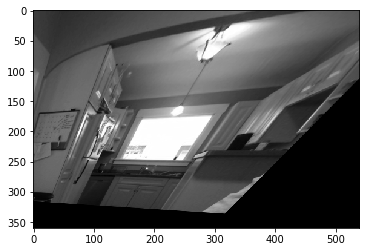

In [51]:
plt.imshow(im_trans, cmap='gray')
plt.show()